<a href="https://colab.research.google.com/github/r0c10/DataScience/blob/master/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Support Vector Machine Introduction

Este notebook muestra cómo implementar varios métodos SVM con TensorFlow. Primero creamos un SVM lineal y también mostramos cómo se puede usar para la regresión. Luego presentamos los núcleos (núcleo gaussiano RBF) y mostramos cómo usarlo para dividir datos no lineales. Terminamos con una implementación multidimensional de SVM no lineales para trabajar con múltiples clases.

1. Introducción  
Presentamos el concepto de SVM y cómo haremos para implementarlos en el marco TensorFlow.
2.  SVM lineales  
Creamos un SVM lineal para separar I. setosa basado en la longitud del sepal y el ancho del pedal en el conjunto de datos de Iris.
3.  Reducción a la regresión lineal  
El corazón de las SVM es separar las clases con una línea. Cambiamos ligeramente el algoritmo para realizar una regresión SVM.
4.  Trabajando con Kernels en TensorFlow  
Para extender los SVM en datos no lineales, explicamos y mostramos cómo implementar diferentes núcleos en TensorFlow.
5. Implementación de SVM no lineales  
Usamos el núcleo gaussiano (RBF) para separar clases no lineales.
6. Implementación de SVM multiclase  
Las SVM son predictores inherentemente binarios. Mostramos cómo extenderlos en una estrategia de uno contra todos en TensorFlow.

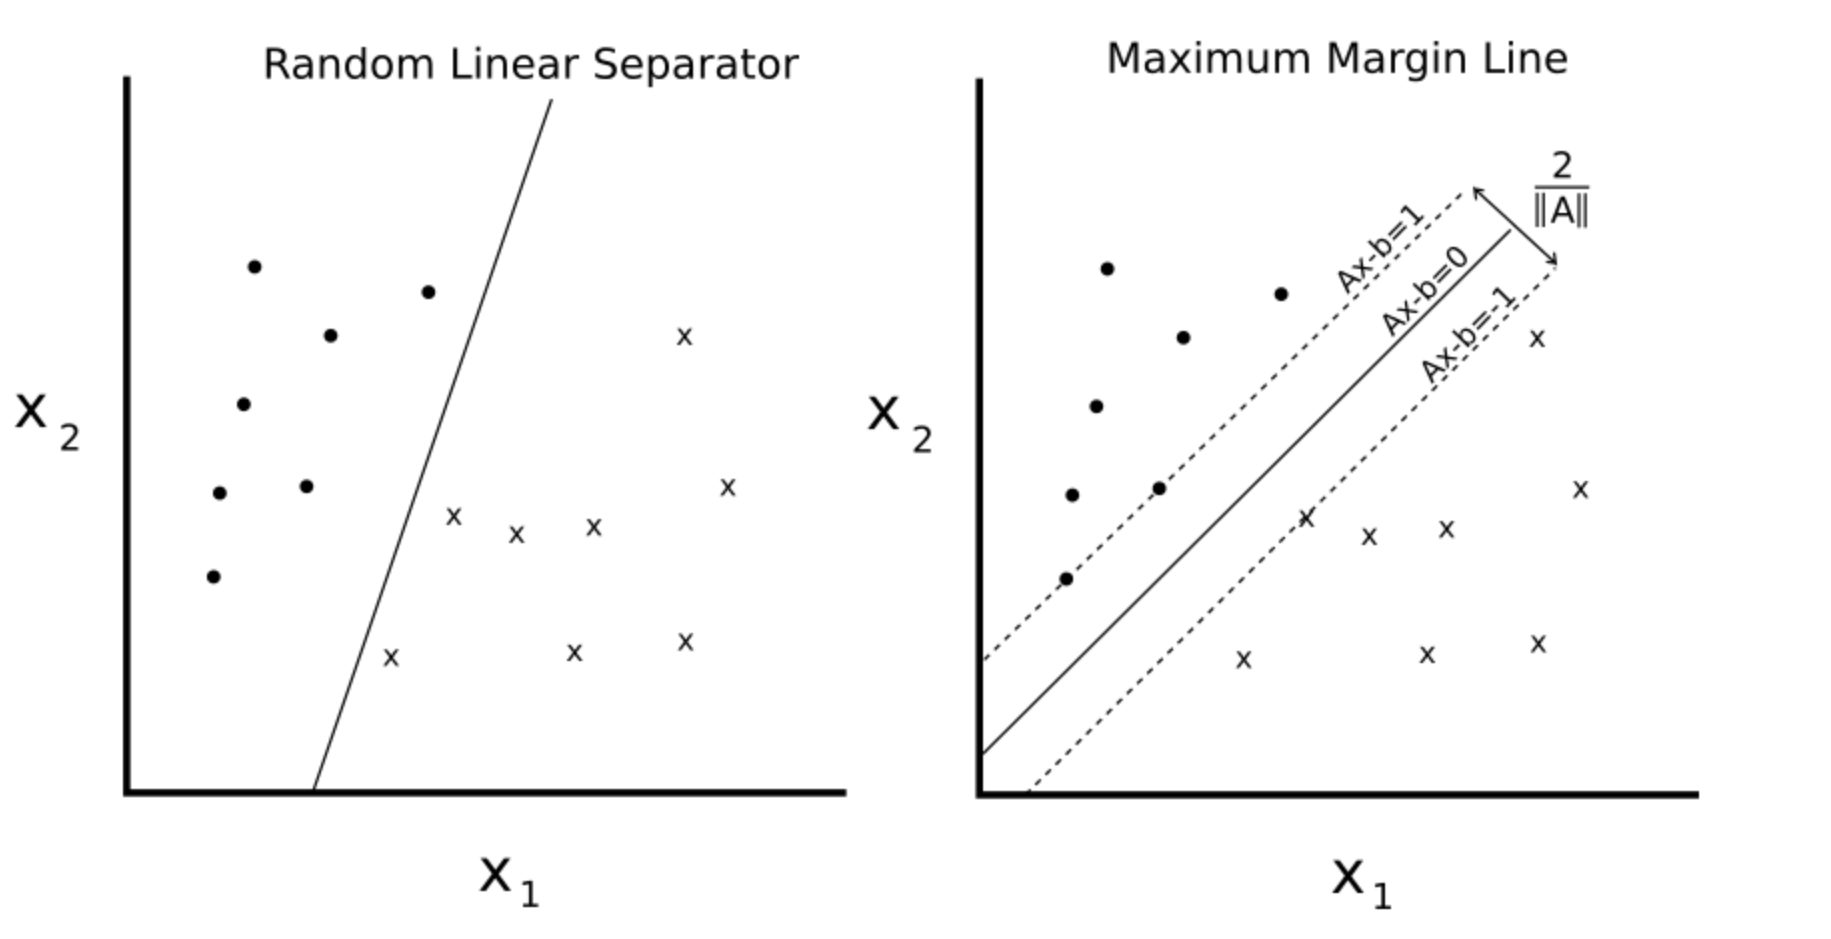

In [2]:
from IPython.display import Image
Image("SVM.png")

Las máquinas de vectores de soporte (SVM) son un método de aprendizaje automático para separar clases binarias. Esto se logra maximizando un ancho de margen entre dos clases. Se extiende para permitir el ruido en los datos, cuando las dos clases no son explícitamente lineales separables. Los SVM pueden ampliarse para separar clases no lineales mediante el uso de núcleos no lineales. Después de esto, terminamos este capítulo mostrando cómo extender estas clasificaciones binarias en problemas de múltiples clases a través de un método de uno contra todos.

### Linear Support Vector Machine: Soft Margin

Esta función muestra cómo usar TensorFlow para crear un SVM de margen suave

Utilizaremos los datos del iris, específicamente:

$x_1 =$ Sepal Length

$x_2 =$ Petal Width

Class 1 : I. setosa

Class -1: not I. setosa


Sabemos aquí que "x" y "y" son linealmente separables para la clasificación de I. setosa.

    Tenga en cuenta que implementamos el margen blando con un margen de error permitido para los puntos. El término de margen de error viene dado por 'alfa' a continuación. Para comportarse como un SVM de margen rígido, establezca alpha = 0.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn import datasets
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [6]:
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()
  print("Enabled compatitility to tf1.x")

Instructions for updating:
non-resource variables are not supported in the long term
Enabled compatitility to tf1.x


In [7]:
#Set a random seed and start a computational graph.

np.random.seed(41)
tf.compat.v1.set_random_seed(41)
sess = tf.Session()

In [8]:
#Load the data

# iris.data = [(Sepal Length, Sepal Width, Petal Length, Petal Width)]
iris = datasets.load_iris()
x_vals = np.array([[x[0], x[3]] for x in iris.data])
y_vals = np.array([1 if y == 0 else -1 for y in iris.target])

In [9]:
#Split data into train/test sets

train_indices = np.random.choice(len(x_vals),
                                 round(len(x_vals)*0.8),
                                 replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

In [10]:
#Set model parameters, placeholders, and coefficients.


# Declare batch size
batch_size = 110

# Initialize placeholders
x_data = tf.placeholder(shape=[None, 2], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

# Create variables for SVM
A = tf.Variable(tf.random_normal(shape=[2, 1]))
b = tf.Variable(tf.random_normal(shape=[1, 1]))

Declara nuestro modelo y Norma L2

El modelo lineal SVM viene dado por la ecuación:

$$\left[ \frac{1}{n} \sum_{i=1}^{n} \max(0, 1 - y_i(A \cdot x - b)) \right] + \alpha \cdot ||A||^{2}$$
Nuestra función de pérdida será la cantidad anterior y le diremos a TensorFlow que lo minimice. Tenga en cuenta que $ n $ es el número de puntos (en un lote), $ A $ es el vector hiperplano normal (para resolver), $ b $ es el desplazamiento del hiperplano (para resolver) y $ \ alpha $ es el parámetro de soft-margin.

In [11]:
# Declare model operations
model_output = tf.subtract(tf.matmul(x_data, A), b)

# Declare vector L2 'norm' function squared
l2_norm = tf.reduce_sum(tf.square(A))

Aquí hacemos que nuestra función de pérdida especial se base en la clasificación de los puntos (en qué lado de la línea caen).

Además, tenga en cuenta que alfa es el término de margen blando y se puede aumentar para permitir puntos de clasificación más erróneos. Para el comportamiento de margen duro, establezca alfa = 0.

In [12]:
# Declare loss function
# Loss = max(0, 1-pred*actual) + alpha * L2_norm(A)^2
# L2 regularization parameter, alpha

alpha = tf.constant([0.01])

# Margin term in loss
classification_term = tf.reduce_mean(tf.maximum(0., tf.subtract(1., tf.multiply(model_output, y_target))))

# Put terms together
loss = tf.add(classification_term, tf.multiply(alpha, l2_norm))

Creando la función de predicción, el algoritmo de optimización e inicializando las variables.

In [13]:
# Declare prediction function
prediction = tf.sign(model_output)
accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, y_target), tf.float32))

# Declare optimizer
my_opt = tf.train.AdamOptimizer(0.005)
train_step = my_opt.minimize(loss)

# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

Ahora podemos comenzar el ciclo de entrenamiento.

In [14]:
# Training loop
loss_vec = []
train_accuracy = []
test_accuracy = []
for i in range(1500):
    rand_index = np.random.choice(len(x_vals_train), size=batch_size)
    rand_x = x_vals_train[rand_index]
    rand_y = np.transpose([y_vals_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})

    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss)

    train_acc_temp = sess.run(accuracy, feed_dict={
        x_data: x_vals_train,
        y_target: np.transpose([y_vals_train])})
    train_accuracy.append(train_acc_temp)

    test_acc_temp = sess.run(accuracy, feed_dict={
        x_data: x_vals_test,
        y_target: np.transpose([y_vals_test])})
    test_accuracy.append(test_acc_temp)

    if (i + 1) % 75 == 0:
        print('Step #{} A = {}, b = {}'.format(
            str(i+1),
            str(sess.run(A)),
            str(sess.run(b))
        ))
        print('Loss = ' + str(temp_loss))

Step #75 A = [[ 0.6396051 ]
 [-0.88766843]], b = [[-1.0392306]]
Loss = [2.8616133]
Step #150 A = [[ 0.26462534]
 [-1.2605739 ]], b = [[-0.6635497]]
Loss = [0.8456727]
Step #225 A = [[ 0.105088]
 [-1.466484]], b = [[-0.52243423]]
Loss = [0.18090914]
Step #300 A = [[ 0.12179337]
 [-1.559698  ]], b = [[-0.5794867]]
Loss = [0.12619878]
Step #375 A = [[ 0.12960869]
 [-1.6553229 ]], b = [[-0.62871665]]
Loss = [0.16008714]
Step #450 A = [[ 0.13229293]
 [-1.7513708 ]], b = [[-0.67252463]]
Loss = [0.10354102]
Step #525 A = [[ 0.13012955]
 [-1.8429034 ]], b = [[-0.71110916]]
Loss = [0.12048084]
Step #600 A = [[ 0.13256167]
 [-1.921474  ]], b = [[-0.75238377]]
Loss = [0.10038178]
Step #675 A = [[ 0.12814555]
 [-1.9801517 ]], b = [[-0.7798519]]
Loss = [0.12779146]
Step #750 A = [[ 0.1284729]
 [-2.0276363]], b = [[-0.8093924]]
Loss = [0.11014418]
Step #825 A = [[ 0.13135567]
 [-2.05822   ]], b = [[-0.8339403]]
Loss = [0.1380677]
Step #900 A = [[ 0.12880525]
 [-2.088446  ]], b = [[-0.84852713]]
Loss

Ahora extraemos los coeficientes lineales y obtenemos la línea de límite SVM.

In [15]:
# Extract coefficients
[[a1], [a2]] = sess.run(A)
[[b]] = sess.run(b)
slope = -a2/a1
y_intercept = b/a1

# Extract x1 and x2 vals
x1_vals = [d[1] for d in x_vals]

# Get best fit line
best_fit = []
for i in x1_vals:
    best_fit.append(slope*i+y_intercept)

# Separate I. setosa
setosa_x = [d[1] for i, d in enumerate(x_vals) if y_vals[i] == 1]
setosa_y = [d[0] for i, d in enumerate(x_vals) if y_vals[i] == 1]
not_setosa_x = [d[1] for i, d in enumerate(x_vals) if y_vals[i] == -1]
not_setosa_y = [d[0] for i, d in enumerate(x_vals) if y_vals[i] == -1]

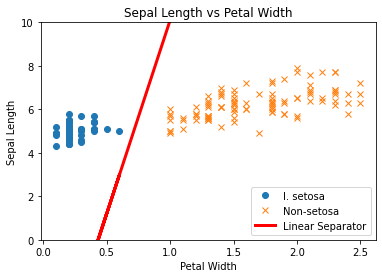

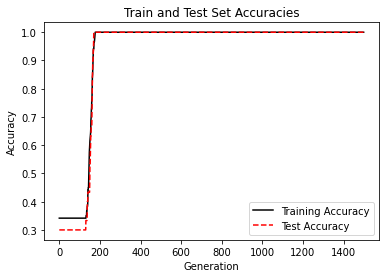

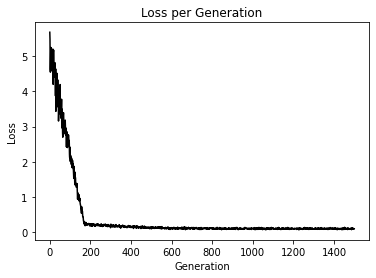

In [16]:
# Matplotlib code for plotting


%matplotlib inline
# Plot data and line
plt.plot(setosa_x, setosa_y, 'o', label='I. setosa')
plt.plot(not_setosa_x, not_setosa_y, 'x', label='Non-setosa')
plt.plot(x1_vals, best_fit, 'r-', label='Linear Separator', linewidth=3)
plt.ylim([0, 10])
plt.legend(loc='lower right')
plt.title('Sepal Length vs Petal Width')
plt.xlabel('Petal Width')
plt.ylabel('Sepal Length')
plt.show()

# Plot train/test accuracies
plt.plot(train_accuracy, 'k-', label='Training Accuracy')
plt.plot(test_accuracy, 'r--', label='Test Accuracy')
plt.title('Train and Test Set Accuracies')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plot loss over time
plt.plot(loss_vec, 'k-')
plt.title('Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()

### SVM Regression
En lugar de optimizar el separador lineal máximo, cambiamos la función de pérdida para maximizar la cantidad de puntos de datos que podemos ajustar en nuestro margen. Esto nos dará una estimación de regresión lineal.

Esta función muestra cómo usar TensorFlow para resolver la regresión de vectores de soporte. Vamos a encontrar la línea que tiene el margen máximo que INCLUYE tantos puntos como sea posible.

Utilizaremos los datos del iris, específicamente:

$y =$ Sepal Length

$x =$ Pedal Width

In [29]:
# Load the data
# iris.data = [(Sepal Length, Sepal Width, Petal Length, Petal Width)]
iris = datasets.load_iris()
x_vals = np.array([x[3] for x in iris.data])
y_vals = np.array([y[0] for y in iris.data])

In [30]:
# Split data into train/test sets
train_indices = np.random.choice(len(x_vals), round(len(x_vals)*0.8), replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

In [34]:
# Declare batch size
batch_size = 50

# Initialize placeholders
x_data = tf.placeholder(shape=[None, 1], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

# Create variables for linear regression
A = tf.Variable(tf.random_normal(shape=[1,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

Creando el modelo

In [35]:
# Declare model operations
model_output = tf.add(tf.matmul(x_data, A), b)

Nuestra función de pérdida, que maximiza la cantidad de puntos cerca de la línea.

In [36]:
# Declare loss function
# = max(0, abs(target - predicted) + epsilon)
# 1/2 margin width parameter = epsilon
epsilon = tf.constant([0.5])
# Margin term in loss
loss = tf.reduce_mean(tf.maximum(0., tf.subtract(tf.abs(tf.subtract(model_output, y_target)), epsilon)))

Creando la función de optimización e inicialice todas las variables del modelo.

In [37]:
# Declare optimizer
my_opt = tf.train.GradientDescentOptimizer(0.075)
train_step = my_opt.minimize(loss)

# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

Recorriendo lotes de datos y optimizando.

In [38]:
# Training loop
train_loss = []
test_loss = []
for i in range(200):
    rand_index = np.random.choice(len(x_vals_train), size=batch_size)
    rand_x = np.transpose([x_vals_train[rand_index]])
    rand_y = np.transpose([y_vals_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    
    temp_train_loss = sess.run(loss, feed_dict={x_data: np.transpose([x_vals_train]), y_target: np.transpose([y_vals_train])})
    train_loss.append(temp_train_loss)
    
    temp_test_loss = sess.run(loss, feed_dict={x_data: np.transpose([x_vals_test]), y_target: np.transpose([y_vals_test])})
    test_loss.append(temp_test_loss)
    if (i+1)%50==0:
        print('-----------')
        print('Generation: ' + str(i+1))
        print('A = ' + str(sess.run(A)) + ' b = ' + str(sess.run(b)))
        print('Train Loss = ' + str(temp_train_loss))
        print('Test Loss = ' + str(temp_test_loss))

-----------
Generation: 50
A = [[2.914658]] b = [[1.4858102]]
Train Loss = 1.0410452
Test Loss = 0.99490285
-----------
Generation: 100
A = [[2.317507]] b = [[2.5373104]]
Train Loss = 0.64898384
Test Loss = 0.6158718
-----------
Generation: 150
A = [[1.7224574]] b = [[3.5063102]]
Train Loss = 0.30248493
Test Loss = 0.28659007
-----------
Generation: 200
A = [[1.3197072]] b = [[4.1873097]]
Train Loss = 0.12583584
Test Loss = 0.11496237


Para trazar, necesitamos extraer los coeficientes y obtener la mejor línea de ajuste. (También los márgenes superior e inferior).

In [39]:
# Extract Coefficients
[[slope]] = sess.run(A)
[[y_intercept]] = sess.run(b)
[width] = sess.run(epsilon)

# Get best fit line
best_fit = []
best_fit_upper = []
best_fit_lower = []
for i in x_vals:
  best_fit.append(slope*i+y_intercept)
  best_fit_upper.append(slope*i+y_intercept+width)
  best_fit_lower.append(slope*i+y_intercept-width)

Código Matplotlib para plotear fit y loss.

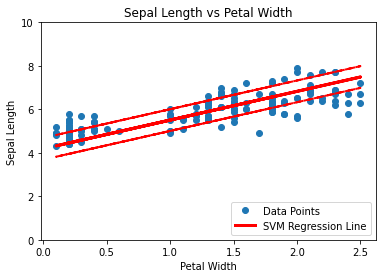

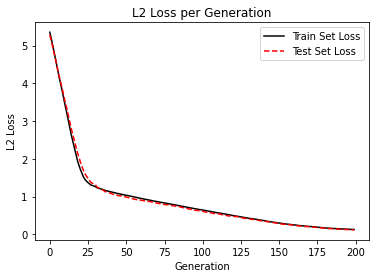

In [40]:
# Plot fit with data
plt.plot(x_vals, y_vals, 'o', label='Data Points')
plt.plot(x_vals, best_fit, 'r-', label='SVM Regression Line', linewidth=3)
plt.plot(x_vals, best_fit_upper, 'r--', linewidth=2)
plt.plot(x_vals, best_fit_lower, 'r--', linewidth=2)
plt.ylim([0, 10])
plt.legend(loc='lower right')
plt.title('Sepal Length vs Petal Width')
plt.xlabel('Petal Width')
plt.ylabel('Sepal Length')
plt.show()

# Plot loss over time
plt.plot(train_loss, 'k-', label='Train Set Loss')
plt.plot(test_loss, 'r--', label='Test Set Loss')
plt.title('L2 Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('L2 Loss')
plt.legend(loc='upper right')
plt.show()

### Working with Kernels
Los SVM lineales son muy potentes. Pero a veces los datos no son muy lineales. Para este fin, podemos usar el 'truco del núcleo' para mapear nuestros datos en un espacio dimensional más alto, donde puede ser linealmente separable. Hacer esto nos permite separar las clases no lineales.

Para este ejemplo, generaremos datos no lineales falsos. Los datos que generaremos son datos de anillos concéntricos.

In [41]:
# Generate non-lnear data
(x_vals, y_vals) = datasets.make_circles(n_samples=350, factor=.5, noise=.1)
y_vals = np.array([1 if y==1 else -1 for y in y_vals])
class1_x = [x[0] for i,x in enumerate(x_vals) if y_vals[i]==1]
class1_y = [x[1] for i,x in enumerate(x_vals) if y_vals[i]==1]
class2_x = [x[0] for i,x in enumerate(x_vals) if y_vals[i]==-1]
class2_y = [x[1] for i,x in enumerate(x_vals) if y_vals[i]==-1]

Declaramos el tamaño del lote (grande para SVM), creamos los marcadores de posición y declaramos la variable $ b $ para el modelo SVM.

In [42]:
# Declare batch size
batch_size = 350

# Initialize placeholders
x_data = tf.placeholder(shape=[None, 2], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)
prediction_grid = tf.placeholder(shape=[None, 2], dtype=tf.float32)

# Create variables for svm
b = tf.Variable(tf.random_normal(shape=[1,batch_size]))

Aquí aplicaremos el núcleo. Tenga en cuenta que el núcleo lineal está comentado. Si elige usar el núcleo lineal, descomente la variable lineal my_kernel y comente las cinco líneas del núcleo RBF.


In [43]:
# Apply kernel
# Linear Kernel
# my_kernel = tf.matmul(x_data, tf.transpose(x_data))

# Gaussian (RBF) kernel
gamma = tf.constant(-50.0)
dist = tf.reduce_sum(tf.square(x_data), 1)
dist = tf.reshape(dist, [-1,1])
sq_dists = tf.add(tf.subtract(dist, tf.multiply(2., tf.matmul(x_data, tf.transpose(x_data)))), tf.transpose(dist))
my_kernel = tf.exp(tf.multiply(gamma, tf.abs(sq_dists)))


Luego calculamos el modelo SVM y creamos una función de pérdida(loss).

In [44]:
# Compute SVM Model
first_term = tf.reduce_sum(b)
b_vec_cross = tf.matmul(tf.transpose(b), b)
y_target_cross = tf.matmul(y_target, tf.transpose(y_target))
second_term = tf.reduce_sum(tf.multiply(my_kernel, tf.multiply(b_vec_cross, y_target_cross)))
loss = tf.negative(tf.subtract(first_term, second_term))

Al igual que creamos el núcleo para los puntos de entrenamiento, necesitamos crear el núcleo para los puntos de prueba / predicción.

Nuevamente, comente / descomente las líneas apropiadas para usar el núcleo lineal o RBF.

In [45]:
# Create Prediction Kernel
# Linear prediction kernel
# my_kernel = tf.matmul(x_data, tf.transpose(prediction_grid))

# Gaussian (RBF) prediction kernel
rA = tf.reshape(tf.reduce_sum(tf.square(x_data), 1),[-1,1])
rB = tf.reshape(tf.reduce_sum(tf.square(prediction_grid), 1),[-1,1])
pred_sq_dist = tf.add(tf.subtract(rA, tf.multiply(2., tf.matmul(x_data, tf.transpose(prediction_grid)))), tf.transpose(rB))
pred_kernel = tf.exp(tf.multiply(gamma, tf.abs(pred_sq_dist)))

Para usar el núcleo para clasificar puntos, creamos una operación de predicción. Esta operación de predicción será el signo (positivo o negativo) de los resultados del modelo. La precisión se puede calcular si conocemos las etiquetas de destino reales.


In [46]:
prediction_output = tf.matmul(tf.multiply(tf.transpose(y_target),b), pred_kernel)
prediction = tf.sign(prediction_output-tf.reduce_mean(prediction_output))
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediction), tf.squeeze(y_target)), tf.float32))

Ahora declaramos el optimizador y las operaciones de inicialización variable.

In [47]:
# Declare optimizer
my_opt = tf.train.GradientDescentOptimizer(0.002)
train_step = my_opt.minimize(loss)

# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

Comenzamos el ciclo de entrenamiento para el SVM. Elegiremos al azar un lote de puntos y ejecutaremos el paso del tren. Luego calculamos la pérdida y la precisión.

In [48]:
# Training loop
loss_vec = []
batch_accuracy = []
for i in range(1000):
    rand_index = np.random.choice(len(x_vals), size=batch_size)
    rand_x = x_vals[rand_index]
    rand_y = np.transpose([y_vals[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    
    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss)
    
    acc_temp = sess.run(accuracy, feed_dict={x_data: rand_x,
                                             y_target: rand_y,
                                             prediction_grid:rand_x})
    batch_accuracy.append(acc_temp)
    
    if (i+1)%250==0:
        print('Step #' + str(i+1))
        print('Loss = ' + str(temp_loss))

Step #250
Loss = 26.037716
Step #500
Loss = -5.390959
Step #750
Loss = -9.9175625
Step #1000
Loss = -11.139622


Para trazar una imagen bonita de las regiones que ajustamos, creamos una malla fina para ejecutar nuestro modelo y obtener las predicciones. (Esto es muy similar al código de trazado SVM de sci-kit learn).


In [49]:
# Create a mesh to plot points in
x_min, x_max = x_vals[:, 0].min() - 1, x_vals[:, 0].max() + 1
y_min, y_max = x_vals[:, 1].min() - 1, x_vals[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
grid_points = np.c_[xx.ravel(), yy.ravel()]
[grid_predictions] = sess.run(prediction, feed_dict={x_data: x_vals,
                                                   y_target: np.transpose([y_vals]),
                                                   prediction_grid: grid_points})
grid_predictions = grid_predictions.reshape(xx.shape)

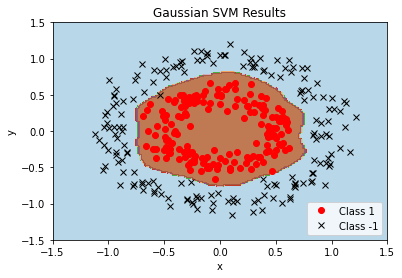

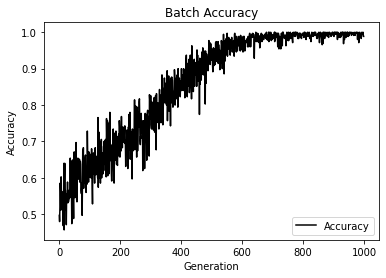

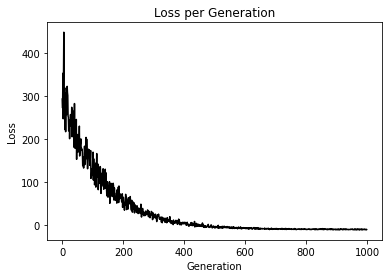

In [50]:
# Plot points and grid
plt.contourf(xx, yy, grid_predictions, cmap=plt.cm.Paired, alpha=0.8)
plt.plot(class1_x, class1_y, 'ro', label='Class 1')
plt.plot(class2_x, class2_y, 'kx', label='Class -1')
plt.title('Gaussian SVM Results')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='lower right')
plt.ylim([-1.5, 1.5])
plt.xlim([-1.5, 1.5])
plt.show()

# Plot batch accuracy
plt.plot(batch_accuracy, 'k-', label='Accuracy')
plt.title('Batch Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plot loss over time
plt.plot(loss_vec, 'k-')
plt.title('Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()

#### Prediction/Evaluation
Aquí hay un código sobre cómo predecir la clase en datos nuevos o no vistos.

In [51]:
# New data points:
new_points = np.array([(-0.75, -0.75),
                       (-0.5, -0.5),
                       (-0.25, -0.25),
                       (0.25, 0.25),
                       (0.5, 0.5),
                       (0.75, 0.75)])

In [52]:
[evaluations] = sess.run(prediction, feed_dict={x_data: x_vals,
                                                y_target: np.transpose([y_vals]),
                                                prediction_grid: new_points})

In [53]:
for ix, p in enumerate(new_points):
    print('{} : class={}'.format(p, evaluations[ix]))

[-0.75 -0.75] : class=-1.0
[-0.5 -0.5] : class=1.0
[-0.25 -0.25] : class=1.0
[0.25 0.25] : class=1.0
[0.5 0.5] : class=1.0
[0.75 0.75] : class=-1.0


## Implementando NonLinear SVMs
Aquí mostramos cómo usar el kernel Gaussian RBF anterior para predecir I.setosa a partir del conjunto de datos de Iris.

Esta función ilustrará cómo implementar el núcleo gaussiano en el conjunto de datos de iris.

Gaussian Kernel:

$$K(x_{1}, x_{2}) = e^{\left(-\gamma \cdot (x_{1} - x_{2})^{2}\right)}$$
Comenzamos cargando las bibliotecas necesarias y restableciendo el gráfico computacional.

Los valores de x values serán $(x_1, x_2)$ donde,

$x_1 =$ 'Sepal Length'

$x_2 =$ 'Petal Width'

Los valores objetivo serán si la especie de flor es Iris Setosa o no.

In [54]:
# Load the data
# iris.data = [(Sepal Length, Sepal Width, Petal Length, Petal Width)]
iris = datasets.load_iris()
x_vals = np.array([[x[0], x[3]] for x in iris.data])
y_vals = np.array([1 if y==0 else -1 for y in iris.target])
class1_x = [x[0] for i,x in enumerate(x_vals) if y_vals[i]==1]
class1_y = [x[1] for i,x in enumerate(x_vals) if y_vals[i]==1]
class2_x = [x[0] for i,x in enumerate(x_vals) if y_vals[i]==-1]
class2_y = [x[1] for i,x in enumerate(x_vals) if y_vals[i]==-1]

### Parametros del modelo 
Ahora declaramos nuestro tamaño de lote, marcadores de posición y el valor b ajustado para el núcleo SVM. Tenga en cuenta que crearemos un marcador de posición separado para alimentar en la cuadrícula de predicción para el trazado.

In [55]:
# Declare batch size
batch_size = 150

# Initialize placeholders
x_data = tf.placeholder(shape=[None, 2], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)
prediction_grid = tf.placeholder(shape=[None, 2], dtype=tf.float32)

# Create variables for svm
b = tf.Variable(tf.random_normal(shape=[1,batch_size]))

### Gaussian (RBF) Kernel
Creamos el núcleo gaussiano que se utiliza para transformar los puntos de datos en un espacio dimensional superior.

El Kernel de dos puntos, $ x $ y $ x '$ se da como

$$K(x, x')=exp\left(-\gamma|| x-x' ||^{2}\right)$$
Para $ \ gamma $ muy pequeño, el núcleo es muy ancho, y viceversa para valores grandes de $ \ gamma $. Esto significa que grandes $ \ gamma $ conducen a modelos de alto sesgo y baja varianza.

Si tenemos un vector de puntos, $ x $ de tamaño (batch_size, 2), entonces nuestro cálculo del núcleo se convierte en

$$K(\textbf{x})=exp\left( -\gamma \textbf{x} \cdot \textbf{x}^{T} \right)$$

In [56]:
# Gaussian (RBF) kernel
gamma = tf.constant(-50.0)
sq_vec = tf.multiply(2., tf.matmul(x_data, tf.transpose(x_data)))
my_kernel = tf.exp(tf.multiply(gamma, tf.abs(sq_vec)))

#### Computando el SVM Model
Aquí, la pérdida de SVM está dada por dos términos, el primer término es la suma de la matriz $ b $, y el segundo término es

$$\sum\left(K\cdot||\textbf{b}||^{2}||\textbf{y}||^{2}\right)$$
Finalmente le decimos a TensorFlow que maximice la pérdida minimizando lo negativo:(La siguiente es una versión horriblemente abreviada del problema dual)

$$-\left(\sum\textbf{b} - \sum\left(K\cdot||\textbf{b}||^{2}||\textbf{y}||^{2}\right)\right)$$

In [57]:
# Compute SVM Model
first_term = tf.reduce_sum(b)
b_vec_cross = tf.matmul(tf.transpose(b), b)
y_target_cross = tf.matmul(y_target, tf.transpose(y_target))
second_term = tf.reduce_sum(tf.multiply(my_kernel, tf.multiply(b_vec_cross, y_target_cross)))
loss = tf.negative(tf.subtract(first_term, second_term))

#### Definiendo la Predicción de Kernel

Ahora hacemos exactamente lo mismo que antes para los puntos de predicción.

In [58]:
# Gaussian (RBF) prediction kernel
rA = tf.reshape(tf.reduce_sum(tf.square(x_data), 1),[-1,1])
rB = tf.reshape(tf.reduce_sum(tf.square(prediction_grid), 1),[-1,1])
pred_sq_dist = tf.add(tf.subtract(rA, tf.multiply(2., tf.matmul(x_data, tf.transpose(prediction_grid)))), tf.transpose(rB))
pred_kernel = tf.exp(tf.multiply(gamma, tf.abs(pred_sq_dist)))

prediction_output = tf.matmul(tf.multiply(tf.transpose(y_target),b), pred_kernel)
prediction = tf.sign(prediction_output-tf.reduce_mean(prediction_output))
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediction), tf.squeeze(y_target)), tf.float32))

#### Método de optimización
Declaramos nuestro optimizador de descenso de gradiente e inicializamos las variables de nuestro modelo (b)

In [59]:
# Declare optimizer
my_opt = tf.train.GradientDescentOptimizer(0.01)
train_step = my_opt.minimize(loss)

# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

#### Ejecutando la clasificación
Repetimos el entrenamiento durante 300 iteraciones. Produciremos la pérdida cada 75 iteraciones.

In [60]:
# Training loop
loss_vec = []
batch_accuracy = []
for i in range(300):
    rand_index = np.random.choice(len(x_vals), size=batch_size)
    rand_x = x_vals[rand_index]
    rand_y = np.transpose([y_vals[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    
    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss)
    
    acc_temp = sess.run(accuracy, feed_dict={x_data: rand_x,
                                             y_target: rand_y,
                                             prediction_grid:rand_x})
    batch_accuracy.append(acc_temp)
    
    if (i+1)%75==0:
        print('Step #' + str(i+1))
        print('Loss = ' + str(temp_loss))

Step #75
Loss = -120.09261
Step #150
Loss = -232.59251
Step #225
Loss = -345.0925
Step #300
Loss = -457.59256


#### Ploteando Resultados
Ahora creamos una malla fina para trazar las líneas de clase SVM

In [61]:
# Create a mesh to plot points in
x_min, x_max = x_vals[:, 0].min() - 1, x_vals[:, 0].max() + 1
y_min, y_max = x_vals[:, 1].min() - 1, x_vals[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
grid_points = np.c_[xx.ravel(), yy.ravel()]
[grid_predictions] = sess.run(prediction, feed_dict={x_data: x_vals,
                                                   y_target: np.transpose([y_vals]),
                                                   prediction_grid: grid_points})
grid_predictions = grid_predictions.reshape(xx.shape)

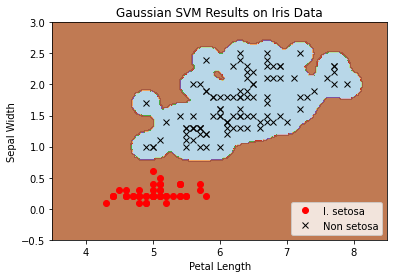

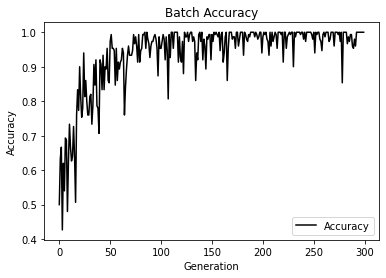

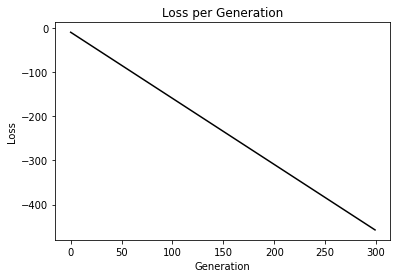

In [62]:
%matplotlib inline
# Plot points and grid
plt.contourf(xx, yy, grid_predictions, cmap=plt.cm.Paired, alpha=0.8)
plt.plot(class1_x, class1_y, 'ro', label='I. setosa')
plt.plot(class2_x, class2_y, 'kx', label='Non setosa')
plt.title('Gaussian SVM Results on Iris Data')
plt.xlabel('Petal Length')
plt.ylabel('Sepal Width')
plt.legend(loc='lower right')
plt.ylim([-0.5, 3.0])
plt.xlim([3.5, 8.5])
plt.show()

# Plot batch accuracy
plt.plot(batch_accuracy, 'k-', label='Accuracy')
plt.title('Batch Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plot loss over time
plt.plot(loss_vec, 'k-')
plt.title('Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()

#### Evaluando el conjunto de pruebas
Creamos un conjunto de puntos de prueba y evaluamos las predicciones de la clase.


In [63]:
x_test_seq = np.array([4., 5., 6., 7.])
y_test_seq = np.array([0., 1., 2.])

x_test, y_test = np.meshgrid(x_test_seq,y_test_seq)
test_points = np.c_[x_test.ravel(), y_test.ravel()]

In [64]:
# Now we can evaluate the predictions on our test points:
test_points

array([[4., 0.],
       [5., 0.],
       [6., 0.],
       [7., 0.],
       [4., 1.],
       [5., 1.],
       [6., 1.],
       [7., 1.],
       [4., 2.],
       [5., 2.],
       [6., 2.],
       [7., 2.]])

In [65]:
[test_predictions] = sess.run(prediction, feed_dict={x_data: x_vals,
                                                     y_target: np.transpose([y_vals]),
                                                     prediction_grid: test_points})

In [66]:
test_predictions.ravel()

array([ 1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1., -1.],
      dtype=float32)

Formatee los puntos de prueba junto con las predicciones:

In [67]:
for ix, point in enumerate(test_points):
    point_pred = test_predictions.ravel()[ix]
    print('Point {} is predicted to be in class {}'.format(point, point_pred))

Point [4. 0.] is predicted to be in class 1.0
Point [5. 0.] is predicted to be in class 1.0
Point [6. 0.] is predicted to be in class 1.0
Point [7. 0.] is predicted to be in class 1.0
Point [4. 1.] is predicted to be in class 1.0
Point [5. 1.] is predicted to be in class -1.0
Point [6. 1.] is predicted to be in class -1.0
Point [7. 1.] is predicted to be in class 1.0
Point [4. 2.] is predicted to be in class 1.0
Point [5. 2.] is predicted to be in class 1.0
Point [6. 2.] is predicted to be in class -1.0
Point [7. 2.] is predicted to be in class -1.0


### Implementando Multiclass SVMs
Aquí, implementamos un método de votación 1 contra todos para un SVM multiclase. Intentamos separar las tres clases de flores Iris con TensorFlow.

Esta función ilustrará cómo implementar el núcleo gaussiano con múltiples clases en el conjunto de datos de iris.

Gaussian Kernel:

$$K(x_1, x_2) = e^{-\gamma \cdot (x_1 - x_2)^2}$$
X : (Sepal Length, Petal Width)

Y: (I. setosa, I. virginica, I. versicolor) (3 classes)

Idea básica: introducir una dimensión extra para hacer una clasificación vs todas.

La predicción de un punto será la categoría con el mayor margen o distancia al límite.

In [68]:
# Load the data
# iris.data = [(Sepal Length, Sepal Width, Petal Length, Petal Width)]
iris = datasets.load_iris()
x_vals = np.array([[x[0], x[3]] for x in iris.data])
y_vals1 = np.array([1 if y==0 else -1 for y in iris.target])
y_vals2 = np.array([1 if y==1 else -1 for y in iris.target])
y_vals3 = np.array([1 if y==2 else -1 for y in iris.target])
y_vals = np.array([y_vals1, y_vals2, y_vals3])
class1_x = [x[0] for i,x in enumerate(x_vals) if iris.target[i]==0]
class1_y = [x[1] for i,x in enumerate(x_vals) if iris.target[i]==0]
class2_x = [x[0] for i,x in enumerate(x_vals) if iris.target[i]==1]
class2_y = [x[1] for i,x in enumerate(x_vals) if iris.target[i]==1]
class3_x = [x[0] for i,x in enumerate(x_vals) if iris.target[i]==2]
class3_y = [x[1] for i,x in enumerate(x_vals) if iris.target[i]==2]

In [69]:
#Declare the batch size

batch_size = 50

Inicializar marcadores de posición y crear las variables para SVM multiclase

In [70]:
# Initialize placeholders
x_data = tf.placeholder(shape=[None, 2], dtype=tf.float32)
y_target = tf.placeholder(shape=[3, None], dtype=tf.float32)
prediction_grid = tf.placeholder(shape=[None, 2], dtype=tf.float32)

# Create variables for svm
b = tf.Variable(tf.random_normal(shape=[3,batch_size]))

Creando el Gaussian Kernel

In [71]:
# Gaussian (RBF) kernel
gamma = tf.constant(-10.0)
dist = tf.reduce_sum(tf.square(x_data), 1)
dist = tf.reshape(dist, [-1,1])
sq_dists = tf.multiply(2., tf.matmul(x_data, tf.transpose(x_data)))
my_kernel = tf.exp(tf.multiply(gamma, tf.abs(sq_dists)))

Declarar una función que hará la remodelación y la multiplicación de la matriz de lotes

In [72]:
# Declare function to do reshape/batch multiplication
def reshape_matmul(mat, _size):
    v1 = tf.expand_dims(mat, 1)
    v2 = tf.reshape(v1, [3, _size, 1])
    return(tf.matmul(v2, v1))

Ahora computmos el modelo SVM

In [73]:
# Compute SVM Model
first_term = tf.reduce_sum(b)
b_vec_cross = tf.matmul(tf.transpose(b), b)
y_target_cross = reshape_matmul(y_target, batch_size)

second_term = tf.reduce_sum(tf.multiply(my_kernel, tf.multiply(b_vec_cross, y_target_cross)),[1,2])
loss = tf.reduce_sum(tf.negative(tf.subtract(first_term, second_term)))

Creando el mismo núcleo RBF para un conjunto de puntos de predicción (utilizado en una cuadrícula de puntos al final).

In [74]:
# Gaussian (RBF) prediction kernel
rA = tf.reshape(tf.reduce_sum(tf.square(x_data), 1),[-1,1])
rB = tf.reshape(tf.reduce_sum(tf.square(prediction_grid), 1),[-1,1])
pred_sq_dist = tf.add(tf.subtract(rA, tf.multiply(2., tf.matmul(x_data, tf.transpose(prediction_grid)))), tf.transpose(rB))
pred_kernel = tf.exp(tf.multiply(gamma, tf.abs(pred_sq_dist)))

prediction_output = tf.matmul(tf.multiply(y_target,b), pred_kernel)
prediction = tf.argmax(prediction_output-tf.expand_dims(tf.reduce_mean(prediction_output,1), 1), 0)
accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, tf.argmax(y_target,0)), tf.float32))

Creando las operaciones de optimización e inicializador variable.

In [75]:
# Declare optimizer
my_opt = tf.train.GradientDescentOptimizer(0.01)
train_step = my_opt.minimize(loss)

# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

Ahora comenzamos el ciclo de entrenamiento para el SVM multiclase.

In [76]:
# Training loop
loss_vec = []
batch_accuracy = []
for i in range(100):
    rand_index = np.random.choice(len(x_vals), size=batch_size)
    rand_x = x_vals[rand_index]
    rand_y = y_vals[:,rand_index]
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    
    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss)
    
    acc_temp = sess.run(accuracy, feed_dict={x_data: rand_x,
                                             y_target: rand_y,
                                             prediction_grid:rand_x})
    batch_accuracy.append(acc_temp)
    
    if (i+1)%25==0:
        print('Step #' + str(i+1))
        print('Loss = ' + str(temp_loss))

Step #25
Loss = -336.0789
Step #50
Loss = -673.5787
Step #75
Loss = -1011.0785
Step #100
Loss = -1348.5782


In [77]:
# Create a mesh to plot points in
x_min, x_max = x_vals[:, 0].min() - 1, x_vals[:, 0].max() + 1
y_min, y_max = x_vals[:, 1].min() - 1, x_vals[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_predictions = sess.run(prediction, feed_dict={x_data: rand_x,
                                                   y_target: rand_y,
                                                   prediction_grid: grid_points})
grid_predictions = grid_predictions.reshape(xx.shape)

Ploteando resultados

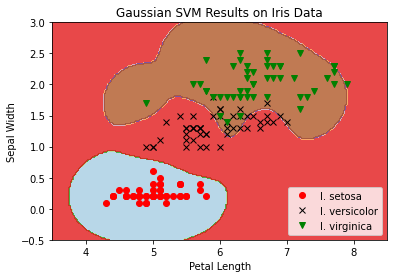

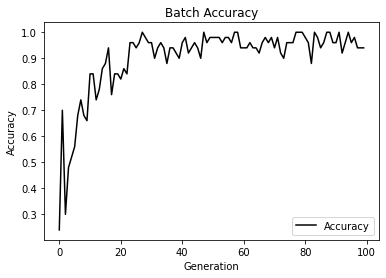

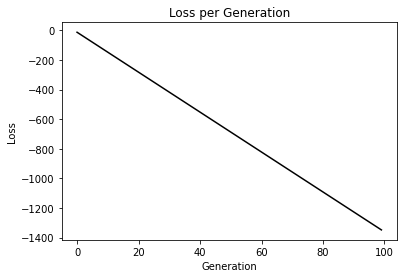

In [78]:
# Plot points and grid
plt.contourf(xx, yy, grid_predictions, cmap=plt.cm.Paired, alpha=0.8)
plt.plot(class1_x, class1_y, 'ro', label='I. setosa')
plt.plot(class2_x, class2_y, 'kx', label='I. versicolor')
plt.plot(class3_x, class3_y, 'gv', label='I. virginica')
plt.title('Gaussian SVM Results on Iris Data')
plt.xlabel('Petal Length')
plt.ylabel('Sepal Width')
plt.legend(loc='lower right')
plt.ylim([-0.5, 3.0])
plt.xlim([3.5, 8.5])
plt.show()

# Plot batch accuracy
plt.plot(batch_accuracy, 'k-', label='Accuracy')
plt.title('Batch Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plot loss over time
plt.plot(loss_vec, 'k-')
plt.title('Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()